In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

import morphine
from morphine.matrixDFT import minimal_dft

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
osys = morphine.OpticalSystem()
osys.add_pupil(morphine.CircularAperture(radius=3))    # pupil radius in meters
osys.add_detector(pixelscale=0.025, fov_arcsec=0.75)  # image plane coordinates in arcseconds



In [3]:
osys.intermediate_wfs

In [4]:
psf,intermediate = osys.propagate_mono(2e-6)

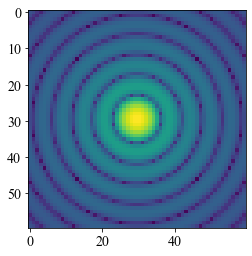

In [5]:
plt.imshow(psf.amplitude**0.25)

In [6]:
arcsec2rad = np.pi/180./3600.
# experimental mathematics for the UV coords
arcsec2rad*psf.pixelscale * psf.shape[0] / 2.e-6*2*osys.planes[0].pupil_diam 

class mywavefront(morphine.AnalyticOpticalElement):
    def __init__(self, wavelength, pupil, phasescreen, **kwargs):
        """ If your optic has adjustible parameters, then save them as attributes here """
        super().__init__()
        self.pupil = pupil
        self.wavelength = wavelength
        self.phasescreen = phasescreen

    def get_opd(self,wave):
        opd = self.phasescreen
        return opd

    def get_transmission(self, wave):
        transmission = self.pupil.get_transmission(wave)
        return transmission

    # behind the scenes morphine  will calculate:
    #    phasor = transmission = np.exp(1.j * 2 * np.pi / wave.wavelength * opd)
def calc_uv(wavefront,osys,npix=128):
    nlamd = arcsec2rad*wavefront.pixelscale * wavefront.shape[0] / wavefront.waves.min()*2*osys.planes[0].pupil_diam
    pupil = wavefront.amplitude**2.
    return minimal_dft(pupil, nlamd, npix)

In [7]:
RADIUS = 2.0 # meters
WAVELENGTH = 2.0e-6 # meters
NWAVELS = 10
WAVELS = np.linspace(WAVELENGTH*0.9,WAVELENGTH*1.1,NWAVELS)
PIXSCALE = 0.06 # arcsec / pix
FOV = 4 # arcsec
NWAVES = 1.0
NPIX = 64

osys = morphine.OpticalSystem(npix=NPIX)
circular_aperture = morphine.CircularAperture(radius=RADIUS)
osys.add_pupil(circular_aperture)

wf = osys.input_wavefront()
# # wfe = mywavefront(wavel,osys.planes[0],np.zeros_like(wf.coordinates()[0]))
# osys.add_pupil(wfe)
osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)

wavedict = {'wavelengths':WAVELS,'weights':np.ones_like(WAVELS)}

psf = osys.calc_psf(source=wavedict)

In [8]:
psf.waves.min()

DeviceArray(1.8e-06, dtype=float32)

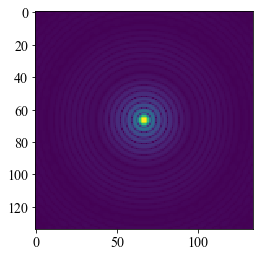

In [9]:
plt.imshow(psf.amplitude**0.5)

In [10]:
uv = (calc_uv(psf,osys))

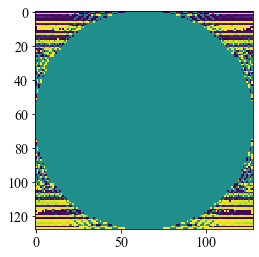

In [11]:
plt.imshow(np.angle(uv))


## Now let's try to autodiff this

In [12]:
def psf_from_phasescreen(phasescreen,wavels=WAVELS):
    osys = morphine.OpticalSystem(npix=NPIX)
    circular_aperture = morphine.CircularAperture(radius=RADIUS,gray_pixel=False)
    osys.add_pupil(circular_aperture)

    wf = osys.input_wavefront()
    wfe = mywavefront(wavels[0],osys.planes[0],phasescreen)
    osys.add_pupil(wfe)
    osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)
    
    psf = osys.calc_psf(source=wavedict)
    return psf,osys

def end_to_end(phasescreen):
    psf, osys = psf_from_phasescreen(phasescreen)
    return calc_uv(psf,osys,npix=NPIX+1)

def uv_phase(phasescreen):
    return np.angle(end_to_end(phasescreen))

zero_phase = np.zeros_like(wf.coordinates()[0])

output = uv_phase(zero_phase)

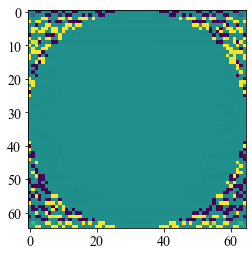

In [13]:
plt.imshow(output)

In [14]:
from jax import jacfwd, jacrev
from time import time as clock

In [15]:
phasegrad = jacrev(uv_phase)

In [16]:
%%time 
thisgrad = phasegrad(zero_phase)


CPU times: user 2min 13s, sys: 41.4 s, total: 2min 54s
Wall time: 2min 56s


In [17]:
tic = clock()
print(thisgrad.sum())
toc = clock()
print(toc-tic)

-864.0
28.38243007659912


In [18]:
thisgrad.shape[3]

64

In [19]:
print(toc-tic)

28.38243007659912


In [20]:
otf = end_to_end(zero_phase)

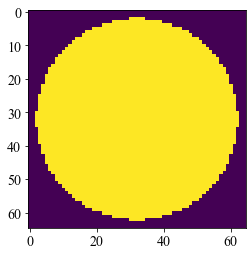

In [45]:
support = np.abs(otf) > 2.227e-5
plt.imshow(support)

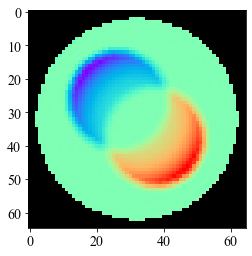

In [47]:
indices = 20

phases = onp.copy(thisgrad[:,:,indices,indices])
phases[support<1.] = np.nan
plt.imshow(phases,cmap=phasemap)


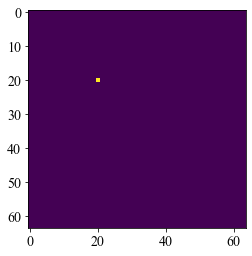

In [48]:
indices = 20
pupil_trans = osys.planes[0].transmission
phasescreen_test = onp.zeros_like(pupil_trans)
phasescreen_test[indices,indices] = 0.1

plt.imshow(phasescreen_test)

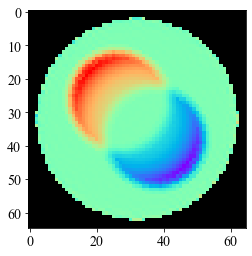

In [49]:
output = onp.array(uv_phase(phasescreen_test))
output[support<1.] = np.nan
plt.imshow(output,cmap=phasemap)


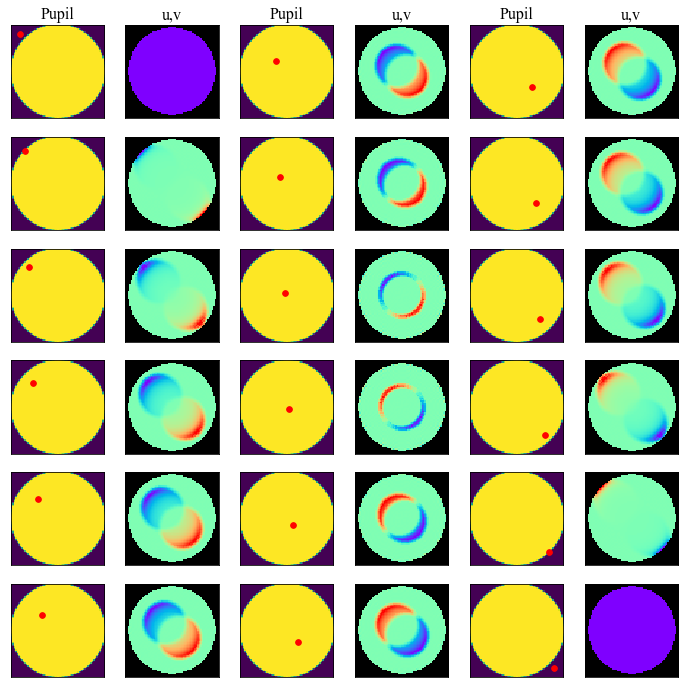

In [50]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 10
fs = 16

index_step = onp.floor((thisgrad.shape[3])/((3.*rows))).astype('int')

indices = index_step+3

for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
#         ax[i,1+j].imshow(thisgrad[indices,indices,:,:],cmap=phasemap)
        phases = onp.copy(thisgrad[:,:,indices,indices])
        pupil_trans = osys.planes[0].transmission
        phases[support<1.] = np.nan
        ax[i,1+j].imshow(phases,cmap=phasemap)

        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('u,v',fontsize=fs)
            ax[i,j].set_title('Pupil',fontsize=fs)

        ax[i,j].imshow(pupil_trans)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

        indices += index_step

# plt.savefig('jacobian.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/anoroc/paper/jacobian_broadband.pdf',bbox_inches='tight')

In [51]:
transfer_martinache = thisgrad[:,:,support>0][pupil_trans==1,:]

In [52]:
transfer_martinache.shape

(3080, 2845)

In [53]:
%%time
u1, s1, v1 = np.linalg.svd(transfer_martinache,full_matrices=False)

CPU times: user 118 ms, sys: 16.9 ms, total: 134 ms
Wall time: 113 ms


In [54]:
s1[6000]/s1[0]

DeviceArray(2.137244e-09, dtype=float32)

In [55]:
np.sum((s1/s1[0])>5e-8)

DeviceArray(940, dtype=int32)

In [56]:
from astropy.table import Table
tab = Table({'S1':s1/s1[0]})
tab.write('svd_broadband.txt',format='ascii')

<module 'matplotlib.pyplot' from '/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

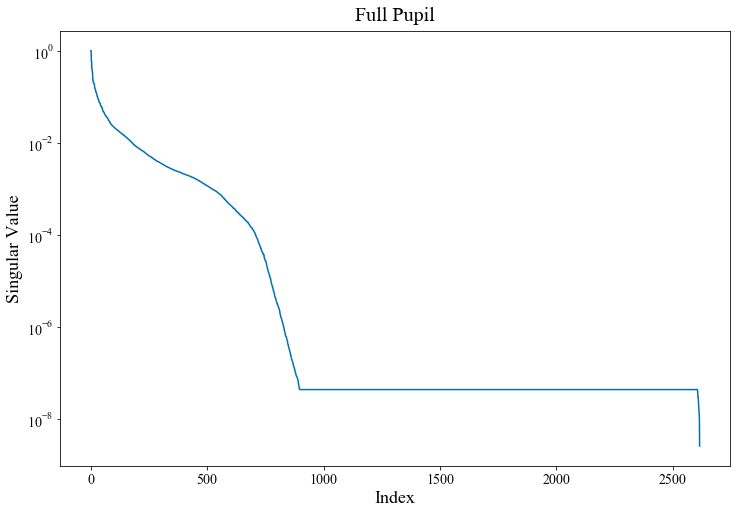

In [32]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s1/s1[0])
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
plt.title('Full Pupil',y=1.01,fontsize=20)
plt
# plt.savefig('kerphi_singular.png',bbox_inches='tight')
# plt.savefig('/Users/benjaminpope/code/anoroc/paper/kerphi_singular.pdf',bbox_inches='tight')

### What do these kernel phase maps look like?

In [33]:
v1.shape

(2617, 2617)

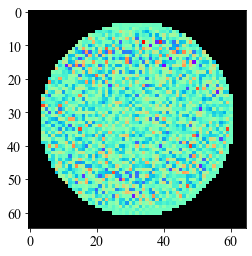

In [34]:
index = 1500

mode = 1.*onp.array(support)
mode[support>0] = v1[index,:]
mode[support<=0] = np.nan

plt.imshow(mode,cmap=phasemap)

In [35]:
u1.shape

(3080, 2617)

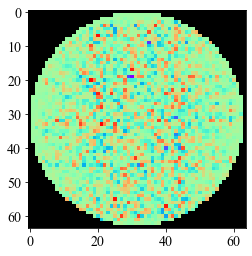

In [36]:
index = 1501

pupil_mode = 1.*onp.array(pupil_trans)
pupil_mode[pupil_trans==1.] = onp.array(u1[:,index])
pupil_mode[pupil_trans!=1.] = np.nan

plt.imshow(pupil_mode,cmap=phasemap)

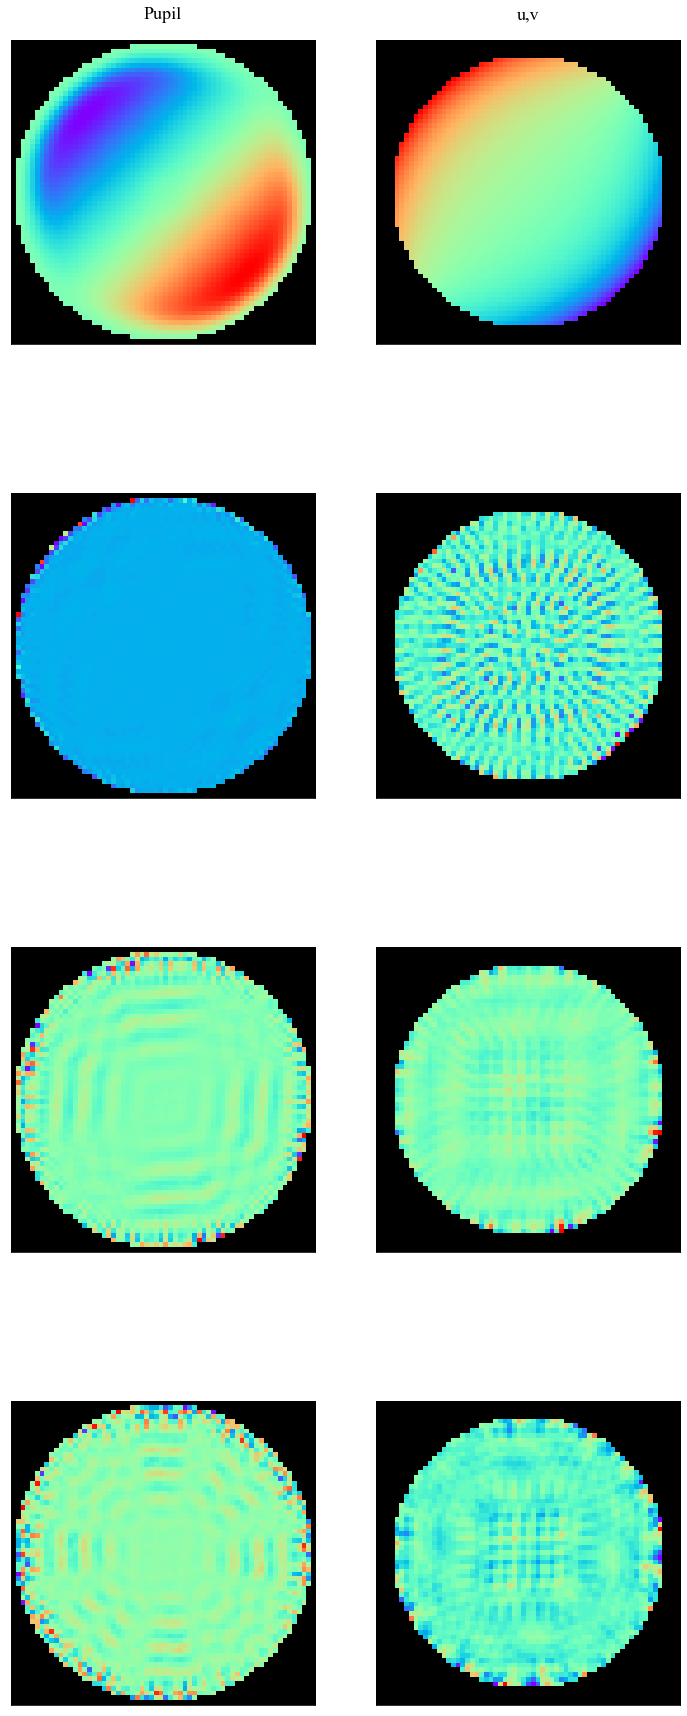

In [37]:
nsets = 4

fig, axes = plt.subplots(nsets,2,figsize=(12.0,12/3.*(nsets*2)))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_title('Pupil',fontsize=18,y=1.05)

axes[0,1].set_title('u,v',fontsize=18,y=1.05)

for j in range(nsets):
    mode = 1.*onp.array(support)
    mode[support>0] = v1[j*50,:]
    mode[support<=0] = np.nan

    axes[j,1].imshow(mode,cmap=phasemap)  
    
    wavefront = onp.ones_like(pupil_trans)
    wavefront[pupil_trans==1.] *= u1[:,j*50]
    wavefront[pupil_trans!=1.] = np.nan
    axes[j,0].imshow(wavefront,cmap=phasemap)
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')


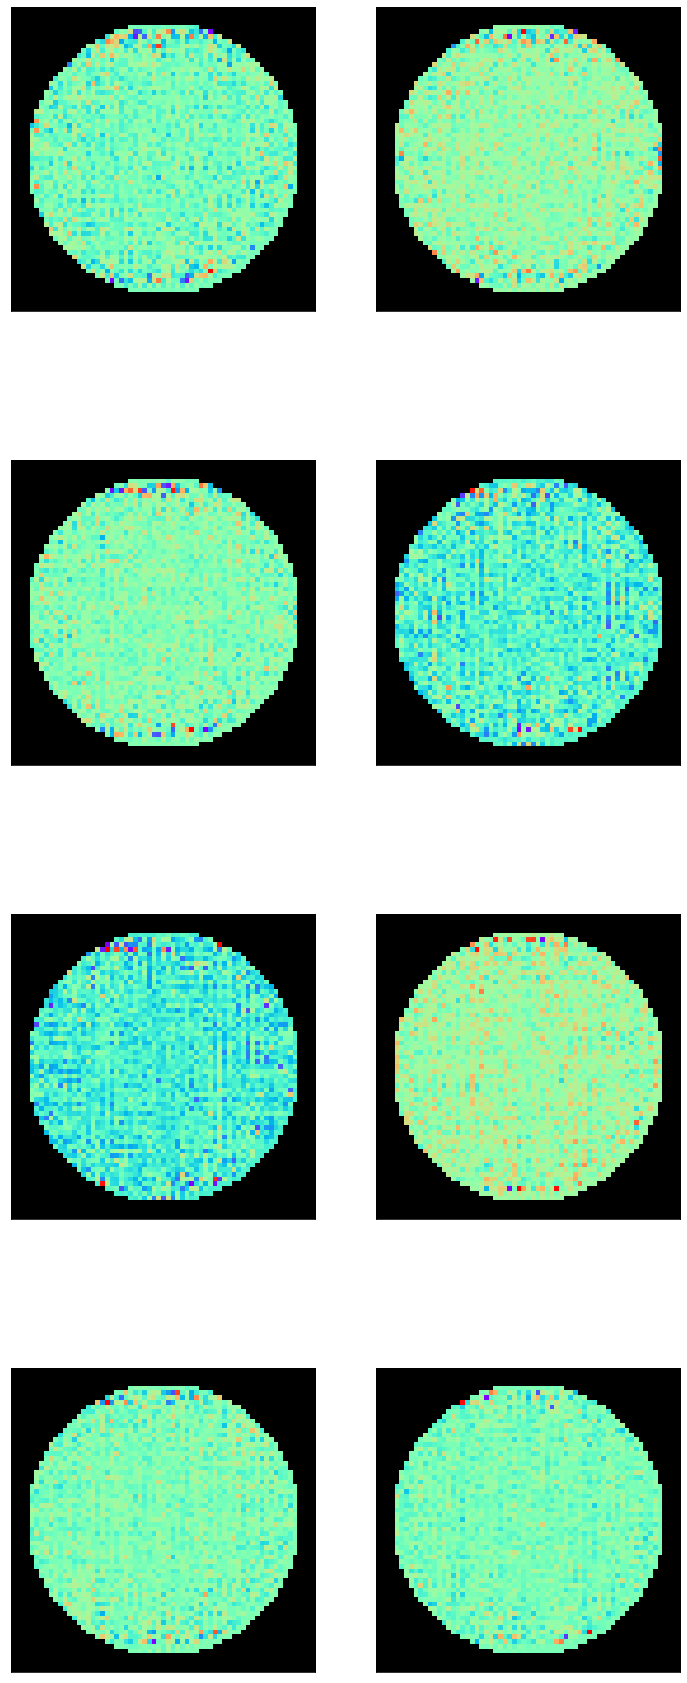

In [38]:
nsets = 4

fig, axes = plt.subplots(nsets,2,figsize=(12.0,12/3.*(nsets*2)))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

for j, axis in enumerate(axes.ravel()):
    mode = 1.*onp.array(support)
    mode[support==1.] = v1[j+1000,:]
    mode[support<1.] = np.nan

    axis.imshow(mode,cmap=phasemap)  
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')
